# DATA620 - Project 1

## Goal:

For your first project, you are asked to:
- Identify and load a network dataset that has some categorical information available for each node.
- For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
- Compare your centrality measures across your categorical groups.

For example, using the dataset from a study of romantic relationships among high school students in Columbus, Ohio [http://researchnews.osu.edu/archive/chains.htm], you might want to determine if there are any differences in your calculated centrality measures between the two sexes.  You might use a t-test or another statistical measure to support your findings.


Dataset Source: https://www.kaggle.com/datasets/sanjeetsinghnaik/top-1000-highest-grossing-movies


# Installing Packages


In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.layout import bipartite_layout
import numpy as np

I started this project by importing the necessary libraries for data manipulation, visualization, and network analysis.

# Loading Dataset

In [74]:
url = 'https://raw.githubusercontent.com/rkasa01/DATA620_Project1/main/Highest%20Holywood%20Grossing%20Movies.csv'
data =pd.read_csv(url)
print(data.head())

   Unnamed: 0                                       Title  \
0           0                                      Avatar   
1           1                           Avengers: Endgame   
2           2                    Avatar: The Way of Water   
3           3                                     Titanic   
4           4  Star Wars: Episode VII - The Force Awakens   

                                          Movie Info  Year  \
0  A paraplegic Marine dispatched to the moon Pan...  2009   
1  After the devastating events of Avengers: Infi...  2019   
2  Jake Sully lives with his newfound family form...  2022   
3  A seventeen-year-old aristocrat falls in love ...  1997   
4  As a new threat to the galaxy rises, Rey, a de...  2015   

                           Distributor                 Budget (in $)  \
0                Twentieth Century Fox                     237000000   
1  Walt Disney Studios Motion Pictures                     356000000   
2                 20th Century Studios  Dece

For the purposes of this project, I decided to work with a Kaggle dataset (found here: https://www.kaggle.com/datasets/sanjeetsinghnaik/top-1000-highest-grossing-movies). This dataset contains data about the top 1000 highest grossing Holywood films, up until September 25, 2023. I uploaded the dataset to Github and extracted it using a raw data link

# Data Exploration

In [75]:
print(data.info())
print(data.describe())
print(data.isnull().sum())
for column in data.columns:
    print(column, ": ", data[column].nunique())
print("Number of duplicate rows:", data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Unnamed: 0                  1000 non-null   int64 
 1   Title                       1000 non-null   object
 2   Movie Info                  1000 non-null   object
 3   Year                        1000 non-null   int64 
 4   Distributor                 999 non-null    object
 5   Budget (in $)               1000 non-null   object
 6   Domestic Opening (in $)     1000 non-null   object
 7   Domestic Sales (in $)       1000 non-null   int64 
 8   International Sales (in $)  1000 non-null   int64 
 9   World Wide Sales (in $)     1000 non-null   int64 
 10  Release Date                1000 non-null   object
 11  Genre                       1000 non-null   object
 12  Running Time                1000 non-null   object
 13  License                     943 non-null    objec

The dataset consists of 1000 entries, each representing a Hollywood movie. It includes information such as the movie title, release year, distributor, budget, domestic and international sales figures, release date, genre, running time, and licensing information. Notably, there are missing values in the 'Distributor' and 'License' columns, with one missing entry in the 'Distributor' column and 57 in the 'License' column. The movies span from as early as 1937 to 2023.

# Preprocessing

In [76]:
selected_data = data.loc[:, ["Title", "Distributor", "Domestic Sales (in $)"]]
print(selected_data.head())

                                        Title  \
0                                      Avatar   
1                           Avengers: Endgame   
2                    Avatar: The Way of Water   
3                                     Titanic   
4  Star Wars: Episode VII - The Force Awakens   

                           Distributor  Domestic Sales (in $)  
0                Twentieth Century Fox              785221649  
1  Walt Disney Studios Motion Pictures              858373000  
2                 20th Century Studios              684075767  
3                   Paramount Pictures              674292608  
4  Walt Disney Studios Motion Pictures              936662225  


I made a new dataframe for the information which we will be using for the purposes of this project. This dataframe contains information on movie titles, distributors, and domestic sales figures for each entry.

# Missing Data

In [77]:
missing_data = selected_data.isnull().sum()
print(missing_data)

Title                    0
Distributor              1
Domestic Sales (in $)    0
dtype: int64


From this new dataframe, this is a missing vale in the "Distributor" variable.

In [78]:
selected_data.dropna(subset=['Distributor'], inplace=True)
missing_data = selected_data.isnull().sum()
print(missing_data.head())

Title                    0
Distributor              0
Domestic Sales (in $)    0
dtype: int64


I decided it was most appropriate to remove that row, seeing as we need the Distributor name for this project, and we cannot impute it.

# Data Visualization

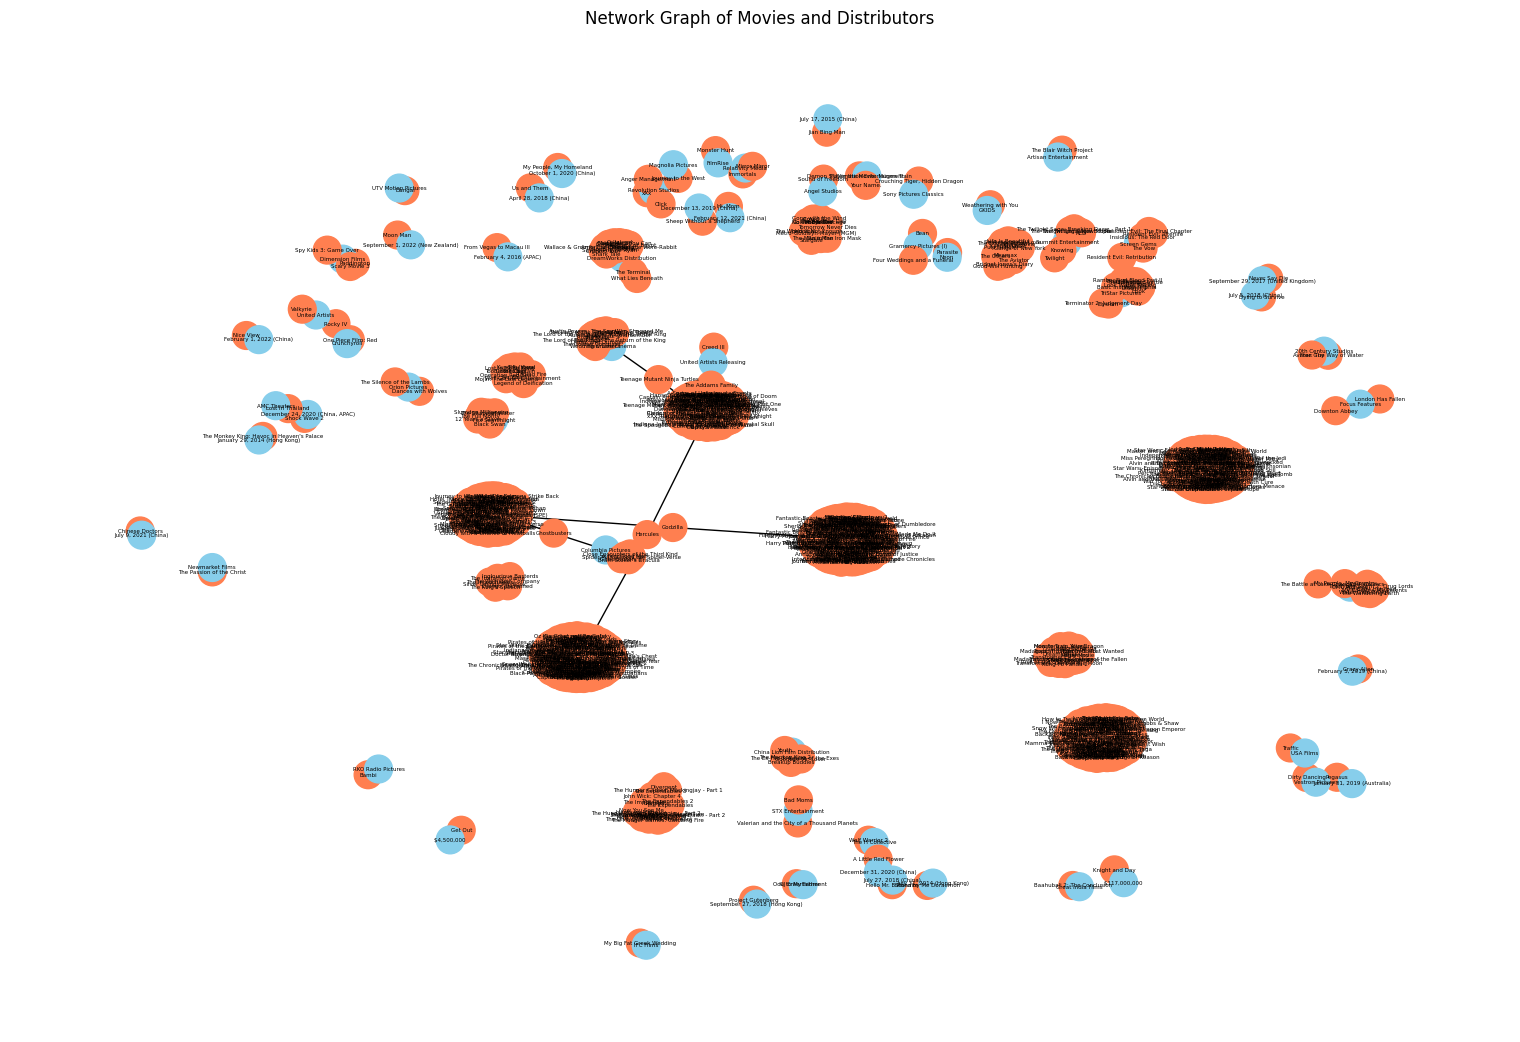

In [84]:
G = nx.Graph()
for index, row in selected_data.iterrows():
    movie = row['Title']
    distributor = row['Distributor']
    G.add_node(movie, type='movie')
    G.add_node(distributor, type='distributor')
    G.add_edge(movie, distributor)
node_colors = {'movie': 'coral', 'distributor': 'skyblue'}
colors = [node_colors[G.nodes[n]['type']] for n in G.nodes()]
plt.figure(figsize=(15, 10))
nx.draw(G, with_labels=True, font_size=4, node_size=400, node_color=colors)
plt.title('Network Graph of Movies and Distributors')
plt.show()

I started by creating a network graph to visualize the relationship between movies and distributors in the selected dataset. Each movie and distributor is represented as a node in the graph, with edges connecting movies to their respective distributors. The nodes are color-coded based on their type, with movies depicted in orange and distributors in blue. The resulting graph is a representation of how many movies are produced by various distributors.

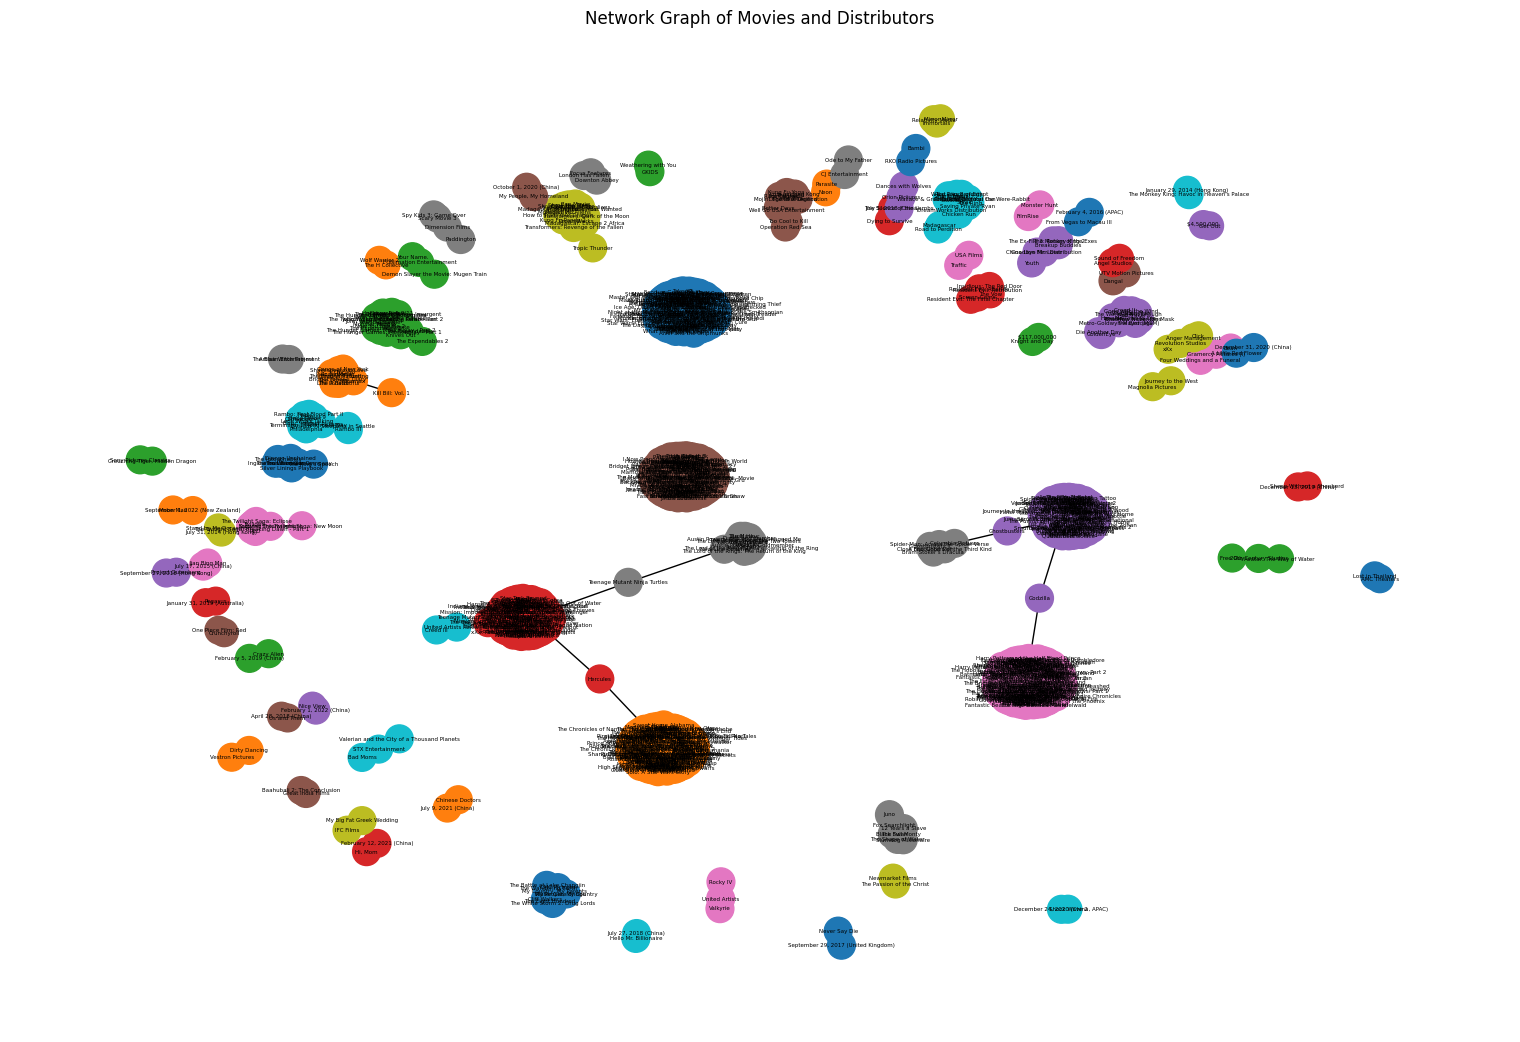

In [85]:
G = nx.Graph()
for index, row in selected_data.iterrows():
    movie = row['Title']
    distributor = row['Distributor']
    G.add_node(movie, type='movie', distributor=distributor)
    G.add_node(distributor, type='distributor')
    G.add_edge(movie, distributor)
distributor_movies = {}
for node, data in G.nodes(data=True):
    if data['type'] == 'movie':
        distributor = data['distributor']
        if distributor not in distributor_movies:
            distributor_movies[distributor] = []
        distributor_movies[distributor].append(node)
node_colors = {}
color_palette = plt.cm.tab10.colors
for i, (distributor, movies) in enumerate(distributor_movies.items()):
    color = color_palette[i % len(color_palette)]
    for movie in movies:
        node_colors[movie] = color
    node_colors[distributor] = color
plt.figure(figsize=(15, 10))
nx.draw(G, with_labels=True, font_size=4, node_size=400, node_color=[node_colors[n] for n in G.nodes()])
plt.title('Network Graph of Movies and Distributors')
plt.show()

Here, I created a network graph to visualize the relationship between movies and distributors, this time grouped by color based on the distributor name. Each movie is connected to its respective distributor, with nodes representing movies and distributors. The nodes are color-coded based on their respective distributors.

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


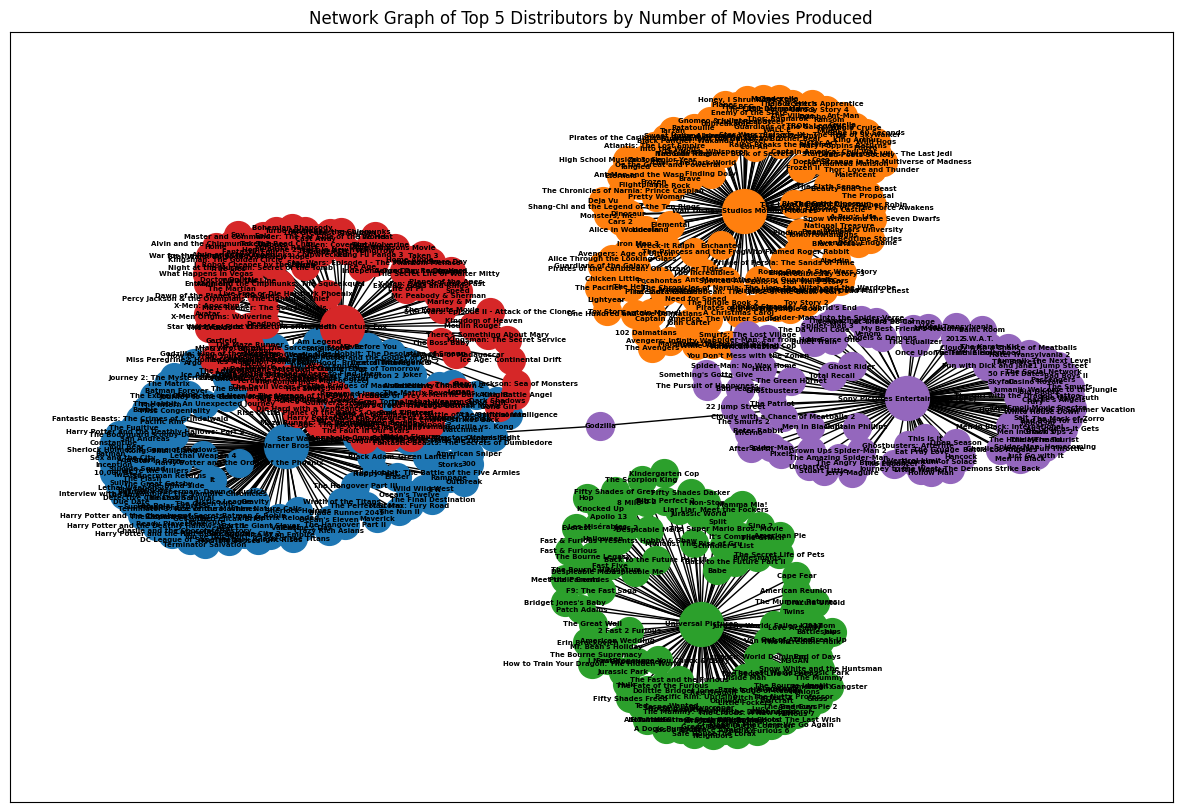

Top 5 Distributors by Number of Movies Produced:
1. Warner Bros.: 165 movies
2. Walt Disney Studios Motion Pictures: 153 movies
3. Universal Pictures: 129 movies
4. Twentieth Century Fox: 123 movies
5. Sony Pictures Entertainment (SPE): 103 movies


In [81]:
G = nx.Graph()
for index, row in selected_data.iterrows():
    movie = row['Title']
    distributor = row['Distributor']
    G.add_node(movie, type='movie', distributor=distributor)
    G.add_node(distributor, type='distributor')
    G.add_edge(movie, distributor)
distributor_counts = {}
for node, data in G.nodes(data=True):
    if data['type'] == 'movie':
        distributor = data['distributor']
        distributor_counts[distributor] = distributor_counts.get(distributor, 0) + 1
top_distributors = sorted(distributor_counts, key=distributor_counts.get, reverse=True)[:5]
filtered_nodes = set()
for node, data in G.nodes(data=True):
    if data['type'] == 'movie' and data['distributor'] in top_distributors:
        filtered_nodes.add(node)
    elif data['type'] == 'distributor' and node in top_distributors:
        filtered_nodes.add(node)
filtered_graph = G.subgraph(filtered_nodes)
color_palette = plt.cm.tab10.colors
distributor_colors = {distributor: color_palette[i % len(color_palette)] for i, distributor in enumerate(top_distributors)}
plt.figure(figsize=(15, 10))
pos = nx.fruchterman_reingold_layout(filtered_graph, k=.15)
for distributor, color in distributor_colors.items():
    movies = [node for node, data in filtered_graph.nodes(data=True) if data['type'] == 'movie' and data['distributor'] == distributor]
    nx.draw_networkx_nodes(filtered_graph, pos, nodelist=movies, node_color=color, node_size=400)
    nx.draw_networkx_nodes(filtered_graph, pos, nodelist=[distributor], node_color=color, node_size=1000)
nx.draw_networkx_edges(filtered_graph, pos)
nx.draw_networkx_labels(filtered_graph, pos, font_size=5, font_color='black', font_weight='bold')
plt.title('Network Graph of Top 5 Distributors by Number of Movies Produced')
plt.show()

print("Top 5 Distributors by Number of Movies Produced:")
for i, distributor in enumerate(top_distributors, start=1):
    print(f"{i}. {distributor}: {distributor_counts[distributor]} movies")

Here, I created a network graph for the top 5 distributors based on the number of movies they have produced from the selected dataset. Each distributor is represented as a node in the graph, with their associated movies connected to them. We can see that the top 5 distributors in this dataset are Warner Bros., Walt Disney Studios Motion Pictures, Universal Pictures, Twentieth Century Fox, and Sony Pictures Entertainment. This indicates their influence in the network, however we can perform a centrality analysis to find out more.

# Centrality Analysis

## Degree Centrality

In [82]:
degree_centrality = {}
total_movies = selected_data['Distributor'].count()
for distributor, count in selected_data['Distributor'].value_counts().items():
    degree_centrality[distributor] = count / total_movies
degree_centrality_df = pd.DataFrame(degree_centrality.items(), columns=['Distributor', 'Degree Centrality'])
print(degree_centrality_df.head())

                           Distributor  Degree Centrality
0                         Warner Bros.           0.166166
1  Walt Disney Studios Motion Pictures           0.159159
2                   Universal Pictures           0.130130
3                Twentieth Century Fox           0.123123
4    Sony Pictures Entertainment (SPE)           0.104104


I calculated the degree centrality for each distributor in the dataset, which represents the fraction of movies a distributor has produced compared to the total number of movies. I can see that, for example, Warner Bros. has a degree centrality of approximately 0.166, indicating that it has produced around 16.6% of the total movies in the dataset. Walt Disney Studios Motion Pictures follows with a degree centrality of approximately 0.159, implying it has produced about 15.9% of the movies.

## Eigenvector Centrality

In [83]:
eigenvector_centrality = {}
total_movies = selected_data['Distributor'].count()
for distributor, count in selected_data['Distributor'].value_counts().items():
    eigenvector_centrality[distributor] = count
max_count = max(eigenvector_centrality.values())
for distributor in eigenvector_centrality:
    eigenvector_centrality[distributor] /= max_count
eigenvector_centrality_df = pd.DataFrame(eigenvector_centrality.items(), columns=['Distributor', 'Eigenvector Centrality'])
print(eigenvector_centrality_df.head())

                           Distributor  Eigenvector Centrality
0                         Warner Bros.                1.000000
1  Walt Disney Studios Motion Pictures                0.957831
2                   Universal Pictures                0.783133
3                Twentieth Century Fox                0.740964
4    Sony Pictures Entertainment (SPE)                0.626506


I then calculated eigenvector centrality scores for each distributor in the dataset. Distributors with higher eigenvector centrality scores are those that are connected to other distributors who are also highly connected, suggesting influence. In this dataset, Warner Bros. has the highest score of 1.0, indicating the greatest influence within the network. Walt Disney Studios Motion Pictures follows closely with a score of 0.958.

# Conclusion

For this project, we explored a dataset containing information about the top 1000 highest-grossing movies, with a focus on the distribution companies. Utilizing network analysis techniques, we visualized the relationships between movies and distributors, and looked at the top five distributors based on the number of movies produced. We then calculated degree centrality and eigenvector centrality measures for each distributor to understand their importance within the network. From our analysis, we observed that Warner Bros. and Walt Disney Studios Motion Pictures were the most influential distributors, both in terms of the number of movies produced and their centrality measures. This suggests their significant presence and impact within the film industry. In the future, I can expand this project by analyzing the other variables as well.